In [13]:
from sklearn.datasets import load_iris 
import numpy as np
from IrisFisher import softmax, softmax_grad, logloss, sigmoid
import matplotlib.pyplot as plt
from seaborn import pairplot
from pandas import DataFrame

In [14]:
data = load_iris()

In [15]:

def UnisonShuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def random_init(size, left = -0.1, right = 0.1):
    return np.random.random(size = size) * (right + left) + left

def net_init_1(params):
    params["L0"] = np.zeros((1, 4))

    params["W0"] = random_init((4, 4))
    params['b0'] = random_init((1, 4))

    params["L1"] = np.zeros((1, 4))
    params["P1"] = np.zeros((1, 4))
    
    params["W1"] = random_init((4, 3))
    params['b1'] = random_init((1, 3))
    
    params["L2"] = np.zeros((1, 3))
    params["P2"] = np.zeros((1, 3))
    
    params["E"] = np.zeros((1,1))
    
def check_shape_1(X, y):
    if X.shape !=  (1, 4):
        raise ValueError("X : Expect shape (1, 4), given {0}".format(X.shape))
    if y.shape !=  (1, 3):
        raise ValueError("X : Expect shape (1, 3), given {0}".format(y.shape))
    
def test_train_split_good(*arrays, **params):
    len_n = len(arrays)
    
    shuffle = params.pop('shuffle', False)
    
def test_train_split(X, y, **options):
    
    
    shuffle = options.pop('shuffle', False)
    test_size = options.pop('test_size', 0.1)
    
    if shuffle:
        X, y = UnisonShuffle(X, y)
    
    np.random.seed(1)
    test_elems = np.random.choice(len(X), int(lenX * test_size), replace=False)
    test_mask = np.zeros(lenX, dtype=bool)
    test_mask[test_elems] = True
    
    return X[~test_mask], y[~test_mask], X[test_mask], y[test_mask] 


In [16]:
class MinMaxNormalizer(): # to [0, 1]
    def __init(self):
        self.max = 0
        self.min = 0
        
    def fit(self, x):
        self.max = np.max(x)
        self.min = np.min(x)
    
    def normalize(self, x):
        x -= self.min
        return x / self.max
    
    def fit_and_normalize(self, x):
        self.fit(x)
        return self.normalize(x)

In [17]:
def forward_prop_1(X, y, params):
    check_shape_1(X, y)
    
    params["L0"] = X

    params["L1"] = np.dot(params["L0"], params["W0"]) + params["b0"]
    params["P1"] = sigmoid(params["L1"])
    
    # params["P1"] = X
    
    params["L2"] = np.dot(params["P1"], params["W1"]) + params["b1"]
    params["P2"] = softmax(params["L2"])
    
    params["E"] = logloss(params["P2"], y)
    
def back_prop_1(X, y, params, giper_params):
    check_shape_1(X, y)
    
    params["dE/dP2"] = - y / params["P2"] # 1x3
    params["dP2/dL2"] = softmax_grad(params["P2"]) # 3x3
    params["dE/dL2"] = np.dot(params["dE/dP2"], params["dP2/dL2"]) # 1x3
    params["dE/dW1"] = np.dot(params["P1"].T, params["dE/dL2"]) #4x3
    params["dE/db1"] = params["dE/dL2"]
    
    params["dE/dP1"] = np.dot(params["dE/dL2"], params["W1"].T)# 1x4
    params["dP1/dL1"] = params["P1"] * (1 - params["P1"]) #1x4
    params["dE/dL1"] = params["dE/dP1"] * params["dP1/dL1"] # 1x4
    # params["dE/dL1"] = np.dot(params["dE/dL2"], params["W1"].T)
    params["dE/dW0"] = np.dot(params["L0"].T, params["dE/dL1"]) # 4x4
    params["dE/db0"] = params["dE/dL1"]
    
    params["W1"] -= giper_params["learning rate"] * params["dE/dW1"]
    params["b1"] -= giper_params["learning rate"] * params["dE/db1"]
    
    params["W0"] -= giper_params["learning rate"] * params["dE/dW0"]
    params["b0"] -= giper_params["learning rate"] * params["dE/db0"]
    

In [18]:
X = data["data"]
y_lables = data["target"]

All_len = len(X)

y = np.zeros((len(y_lables), 3))
for i, a in enumerate(y_lables):
    y[i][a] = 1

df= DataFrame(X)
df["labels"] = y_lables

X = X.reshape(-1, 1, 4)
y = y.reshape(-1, 1, 3)

In [19]:
TEST_SIZE = 30

test_len = TEST_SIZE
train_len = All_len - test_len

X_train, y_train, X_test, y_test = test_train_split(X, y, shuffle=True, test_len=(test_len/All_len))

In [20]:

#strart from here 
normalizer = MinMaxNormalizer()
X_train = normalizer.fit_and_normalize(X_train)
X_test = normalizer.normalize(X_test)


params = dict()
giper_params = dict()
giper_params["learning rate"] = 0.01
lenX = len(y)

# pairplot(df, vars=[0, 1, 2, 3],  hue="labels")
# pairplot(dfN, vars=[0, 1, 2, 3],  hue="labels")


net_init_1(params)
    

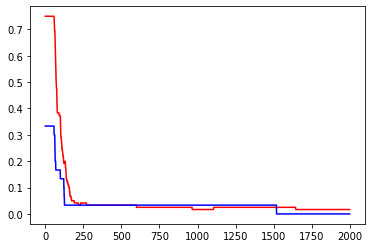

In [24]:
test_accuracy = []
train_accuracy = []
time = []

for i in range(train_len * 2000):
    X_cur = X_train[i % train_len]
    y_cur = y_train[i % train_len]
    forward_prop_1(X_cur, y_cur, params)
    back_prop_1(X_cur, y_cur, params, giper_params)
    if (i % train_len) == train_len - 1:
        time.append(i // train_len)
        error_counter = 0
        for iter, item in enumerate(y_test):
            X_cur = X_test[iter]
            y_cur = y_test[iter]
            forward_prop_1(X_cur, y_cur, params)
            if np.argmax(y_cur) != np.argmax(params["P2"]):
                error_counter += 1
            # print(np.argmax(y_cur), np.argmax(params["P2"]))
            # print(params["P2"])
        test_accuracy.append(error_counter/TEST_SIZE)
        # print(error_counter/TEST_SIZE, end = "  ")
        
        error_counter = 0
        for iter, item in enumerate(y_train):
            X_cur = X_train[iter]
            y_cur = y_train[iter]
            forward_prop_1(X_cur, y_cur, params)
            if np.argmax(y_cur) != np.argmax(params["P2"]):
                error_counter += 1
            # print(np.argmax(y_cur), np.argmax(params["P2"]))
            # print(params["P2"])
        train_accuracy.append(error_counter/train_len)
        # print(error_counter/All_len)
    
plt.plot(time, train_accuracy, "r")
plt.plot(time, test_accuracy, "b")
plt.show()

In [ ]:
print(train_accuracy)

In [ ]:
error_counter = 0


for iter, item in enumerate(y):
    X_cur = X[iter % lenX]
    y_cur = y[iter % lenX]
    forward_prop_1(X_cur, y_cur, params)
    if np.argmax(y_cur) != np.argmax(params["P2"]):
        error_counter += 1
    # print(np.argmax(y_cur), np.argmax(params["P2"]))
    # print(params["P2"])
print(error_counter)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,